# Recurrent Neural Networks

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Overview

The structure of the direcotry should be as follows:

```
.
├── data
│   ├── train.pkl
│   └── test_no_target.pkl
└── main.ipynb
```



## Setup

Select the device to use

In [1]:
!nvidia-smi

Sun May 25 13:14:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:1C:00.0  On |                  N/A |
|  0%   48C    P8             18W /  130W |     875MiB /   6144MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



In [3]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import numpy as np
import os
import random
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### Config for reproductivity

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data preparation

Load the data

In [5]:
train_path = "data/train.pkl"

In [6]:
def load_data(file_path):
    """Loads data from a pickle file."""
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None


In [7]:
train_data = load_data(train_path)

print(f"Loaded {len(train_data)} training samples.")

print(train_data[0])

Loaded 2939 training samples.
(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.], shape=(4756,)), 0)


In [8]:
compositors = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
num_classes = len(compositors)

In [9]:
import numpy as np

sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in train_data]
labels = [label for (seq, label) in train_data]

# Find the max chord index (vocab size, since chords are ints)
all_chords = set()
for seq in sequences:
    all_chords.update(seq.tolist())
vocab_size = int(max(all_chords)) + 2  # +1 for max, +1 for padding idx=0

print(f"Vocab size: {vocab_size}")

Vocab size: 193


In [10]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class ChordDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [seq + 1 for seq in sequences]
        self.labels = labels
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    padded_seqs = pad_sequence(seqs, batch_first=True, padding_value=0)
    return padded_seqs, lengths, torch.tensor(labels, dtype=torch.long)


In [11]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 256

train_data_split, val_data_split = train_test_split(train_data, test_size=0.2, random_state=42)

train_sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in train_data_split]
train_labels = [label for (seq, label) in train_data_split]
val_sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in val_data_split]
val_labels = [label for (seq, label) in val_data_split]

train_dataset = ChordDataset(train_sequences, train_labels)
val_dataset = ChordDataset(val_sequences, val_labels)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [12]:
from torch.utils.data import WeightedRandomSampler

class_sample_counts = np.array([train_labels.count(i) for i in range(num_classes)])
weights = 1. / class_sample_counts

sample_weights = np.array([weights[label] for label in train_labels])
sample_weights = torch.DoubleTensor(sample_weights)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

sampled_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=collate_fn)

## Model

In [13]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout_p=0.5, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0) # padding_idx=0 assumes 0 is used for padding

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,  
            dropout=dropout_p if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        self.dropout = nn.Dropout(dropout_p)

        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # LSTM
        packed_output, (h_n, c_n) = self.lstm(packed_embedded)

    
        if self.bidirectional:
            h_n_last_layer_forward = h_n[-2, :, :]
            h_n_last_layer_backward = h_n[-1, :, :]
            hidden = torch.cat((h_n_last_layer_forward, h_n_last_layer_backward), dim=1)
        else:
            hidden = h_n[-1, :, :]


        hidden = self.dropout(hidden)
        logits = self.fc(hidden)
        return logits

In [ ]:
VOCAB_SIZE = vocab_size
EMBED_DIM = 32
HIDDEN_DIM = 64
OUTPUT_DIM = 5
NUM_LAYERS = 2
DROPOUT_P = 0.4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

In [ ]:
model = LSTMClassifier(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        num_layers=NUM_LAYERS,
        dropout_p=DROPOUT_P,
        bidirectional=False
    ).to(device)

In [ ]:
# norm
counts = torch.tensor([1630, 478, 154, 441, 236], dtype=torch.float) # from data-exploration
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(counts)  # Normalize to num_classes


criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)



In [ ]:
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


LSTMClassifier(
  (embedding): Embedding(193, 32, padding_idx=0)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)
Number of parameters: 64869


In [ ]:
from training import Trainer

trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    early_stopping=True,
)

trainer.train(train_loader, val_loader, epochs=100)


Epoch 1/100: 100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Epoch 1/100 | Train Loss: 1.6058 | Train Acc: 0.0910 | Val Loss: 1.5870 | Val Acc: 0.1190 | LR: 0.001000


Epoch 2/100: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


Epoch 2/100 | Train Loss: 1.5789 | Train Acc: 0.2318 | Val Loss: 1.5474 | Val Acc: 0.3588 | LR: 0.001000


Epoch 3/100: 100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


Epoch 3/100 | Train Loss: 1.5296 | Train Acc: 0.4266 | Val Loss: 1.4894 | Val Acc: 0.5340 | LR: 0.001000


Epoch 4/100: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


Epoch 4/100 | Train Loss: 1.4773 | Train Acc: 0.5427 | Val Loss: 1.4677 | Val Acc: 0.5816 | LR: 0.001000


Epoch 5/100: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


Epoch 5/100 | Train Loss: 1.4219 | Train Acc: 0.5572 | Val Loss: 1.3863 | Val Acc: 0.5527 | LR: 0.001000


Epoch 6/100: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it]


Epoch 6/100 | Train Loss: 1.3388 | Train Acc: 0.5402 | Val Loss: 1.2640 | Val Acc: 0.6054 | LR: 0.001000


Epoch 7/100: 100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


Epoch 7/100 | Train Loss: 1.2136 | Train Acc: 0.5483 | Val Loss: 1.1348 | Val Acc: 0.5680 | LR: 0.001000


Epoch 8/100: 100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


Epoch 8/100 | Train Loss: 1.1091 | Train Acc: 0.5980 | Val Loss: 1.0562 | Val Acc: 0.6190 | LR: 0.001000


Epoch 9/100: 100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Epoch 9/100 | Train Loss: 1.0320 | Train Acc: 0.6223 | Val Loss: 0.9935 | Val Acc: 0.6582 | LR: 0.001000


Epoch 10/100: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it]


Epoch 10/100 | Train Loss: 0.9509 | Train Acc: 0.6767 | Val Loss: 0.9627 | Val Acc: 0.7194 | LR: 0.001000


Epoch 11/100: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it]


Epoch 11/100 | Train Loss: 0.8807 | Train Acc: 0.7023 | Val Loss: 0.9241 | Val Acc: 0.6701 | LR: 0.001000


Epoch 12/100: 100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


Epoch 12/100 | Train Loss: 0.8821 | Train Acc: 0.6972 | Val Loss: 0.9153 | Val Acc: 0.7126 | LR: 0.001000


Epoch 13/100: 100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


Epoch 13/100 | Train Loss: 0.8859 | Train Acc: 0.6908 | Val Loss: 0.8512 | Val Acc: 0.6769 | LR: 0.001000


Epoch 14/100: 100%|██████████| 10/10 [00:35<00:00,  3.59s/it]


Epoch 14/100 | Train Loss: 0.7847 | Train Acc: 0.7150 | Val Loss: 0.8303 | Val Acc: 0.6956 | LR: 0.001000


Epoch 15/100: 100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


Epoch 15/100 | Train Loss: 0.7394 | Train Acc: 0.7184 | Val Loss: 0.8490 | Val Acc: 0.7109 | LR: 0.001000
Early stopping counter: 1/8


Epoch 16/100: 100%|██████████| 10/10 [00:36<00:00,  3.67s/it]


Epoch 16/100 | Train Loss: 0.6928 | Train Acc: 0.7363 | Val Loss: 0.8019 | Val Acc: 0.7007 | LR: 0.001000


Epoch 17/100: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


Epoch 17/100 | Train Loss: 0.6666 | Train Acc: 0.7478 | Val Loss: 0.7761 | Val Acc: 0.7466 | LR: 0.001000


Epoch 18/100: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


Epoch 18/100 | Train Loss: 0.6247 | Train Acc: 0.7720 | Val Loss: 0.7411 | Val Acc: 0.7160 | LR: 0.001000


Epoch 19/100: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


Epoch 19/100 | Train Loss: 0.5778 | Train Acc: 0.7797 | Val Loss: 0.7099 | Val Acc: 0.7670 | LR: 0.001000


Epoch 20/100: 100%|██████████| 10/10 [00:32<00:00,  3.30s/it]


Epoch 20/100 | Train Loss: 0.7094 | Train Acc: 0.6325 | Val Loss: 0.7333 | Val Acc: 0.7483 | LR: 0.001000
Early stopping counter: 1/8


Epoch 21/100: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


Epoch 21/100 | Train Loss: 0.5807 | Train Acc: 0.7869 | Val Loss: 0.7292 | Val Acc: 0.7245 | LR: 0.001000
Early stopping counter: 2/8


Epoch 22/100: 100%|██████████| 10/10 [00:31<00:00,  3.17s/it]


Epoch 22/100 | Train Loss: 0.6004 | Train Acc: 0.7320 | Val Loss: 1.0446 | Val Acc: 0.3452 | LR: 0.001000
Early stopping counter: 3/8


Epoch 23/100: 100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


Epoch 23/100 | Train Loss: 0.7897 | Train Acc: 0.4109 | Val Loss: 0.8280 | Val Acc: 0.4422 | LR: 0.001000
Early stopping counter: 4/8


Epoch 24/100: 100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


Epoch 24/100 | Train Loss: 0.6907 | Train Acc: 0.6410 | Val Loss: 0.8003 | Val Acc: 0.7143 | LR: 0.001000
Early stopping counter: 5/8


Epoch 25/100: 100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


Epoch 25/100 | Train Loss: 0.6110 | Train Acc: 0.7227 | Val Loss: 0.7291 | Val Acc: 0.7517 | LR: 0.000500
Early stopping counter: 6/8


Epoch 26/100: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it]


Epoch 26/100 | Train Loss: 0.5536 | Train Acc: 0.7707 | Val Loss: 0.7199 | Val Acc: 0.7483 | LR: 0.000500
Early stopping counter: 7/8


Epoch 27/100: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


Epoch 27/100 | Train Loss: 0.5256 | Train Acc: 0.7771 | Val Loss: 0.7001 | Val Acc: 0.7823 | LR: 0.000500


Epoch 28/100: 100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


Epoch 28/100 | Train Loss: 0.5304 | Train Acc: 0.8124 | Val Loss: 0.7586 | Val Acc: 0.7143 | LR: 0.000500
Early stopping counter: 1/8


Epoch 29/100: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


Epoch 29/100 | Train Loss: 0.5591 | Train Acc: 0.7516 | Val Loss: 0.7265 | Val Acc: 0.7432 | LR: 0.000500
Early stopping counter: 2/8


Epoch 30/100: 100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


Epoch 30/100 | Train Loss: 0.4963 | Train Acc: 0.7886 | Val Loss: 0.7470 | Val Acc: 0.7687 | LR: 0.000500
Early stopping counter: 3/8


Epoch 31/100: 100%|██████████| 10/10 [00:35<00:00,  3.52s/it]


Epoch 31/100 | Train Loss: 0.4795 | Train Acc: 0.8056 | Val Loss: 0.6733 | Val Acc: 0.7670 | LR: 0.000500


Epoch 32/100: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


Epoch 32/100 | Train Loss: 0.4560 | Train Acc: 0.8116 | Val Loss: 0.7232 | Val Acc: 0.7772 | LR: 0.000500
Early stopping counter: 1/8


Epoch 33/100: 100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Epoch 33/100 | Train Loss: 0.4545 | Train Acc: 0.8124 | Val Loss: 0.6638 | Val Acc: 0.7636 | LR: 0.000500


Epoch 34/100: 100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Epoch 34/100 | Train Loss: 0.4321 | Train Acc: 0.8265 | Val Loss: 0.6813 | Val Acc: 0.8010 | LR: 0.000500
Early stopping counter: 1/8


Epoch 35/100: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


Epoch 35/100 | Train Loss: 0.4253 | Train Acc: 0.8324 | Val Loss: 0.7056 | Val Acc: 0.7925 | LR: 0.000500
Early stopping counter: 2/8


Epoch 36/100: 100%|██████████| 10/10 [00:35<00:00,  3.57s/it]


Epoch 36/100 | Train Loss: 0.4376 | Train Acc: 0.8111 | Val Loss: 0.7105 | Val Acc: 0.7806 | LR: 0.000500
Early stopping counter: 3/8


Epoch 37/100: 100%|██████████| 10/10 [00:37<00:00,  3.74s/it]


Epoch 37/100 | Train Loss: 0.4454 | Train Acc: 0.8307 | Val Loss: 0.6468 | Val Acc: 0.7602 | LR: 0.000500


Epoch 38/100: 100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Epoch 38/100 | Train Loss: 0.4916 | Train Acc: 0.7903 | Val Loss: 0.6268 | Val Acc: 0.8010 | LR: 0.000500


Epoch 39/100: 100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


Epoch 39/100 | Train Loss: 0.4354 | Train Acc: 0.8358 | Val Loss: 0.7692 | Val Acc: 0.7925 | LR: 0.000500
Early stopping counter: 1/8


Epoch 40/100: 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


Epoch 40/100 | Train Loss: 0.4128 | Train Acc: 0.8307 | Val Loss: 0.7266 | Val Acc: 0.8061 | LR: 0.000500
Early stopping counter: 2/8


Epoch 41/100: 100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


Epoch 41/100 | Train Loss: 0.3922 | Train Acc: 0.8520 | Val Loss: 0.6711 | Val Acc: 0.8163 | LR: 0.000500
Early stopping counter: 3/8


Epoch 42/100: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


Epoch 42/100 | Train Loss: 0.3796 | Train Acc: 0.8460 | Val Loss: 0.6760 | Val Acc: 0.8214 | LR: 0.000500
Early stopping counter: 4/8


Epoch 43/100: 100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


Epoch 43/100 | Train Loss: 0.3712 | Train Acc: 0.8503 | Val Loss: 0.6298 | Val Acc: 0.7891 | LR: 0.000500
Early stopping counter: 5/8


Epoch 44/100: 100%|██████████| 10/10 [00:34<00:00,  3.41s/it]


Epoch 44/100 | Train Loss: 0.3698 | Train Acc: 0.8464 | Val Loss: 0.7511 | Val Acc: 0.8231 | LR: 0.000250
Early stopping counter: 6/8


Epoch 45/100: 100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


Epoch 45/100 | Train Loss: 0.3831 | Train Acc: 0.8558 | Val Loss: 0.7010 | Val Acc: 0.8214 | LR: 0.000250
Early stopping counter: 7/8


Epoch 46/100: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


Epoch 46/100 | Train Loss: 0.3515 | Train Acc: 0.8550 | Val Loss: 0.6673 | Val Acc: 0.8146 | LR: 0.000250
Early stopping counter: 8/8
Early stopping triggered after 46 epochs.


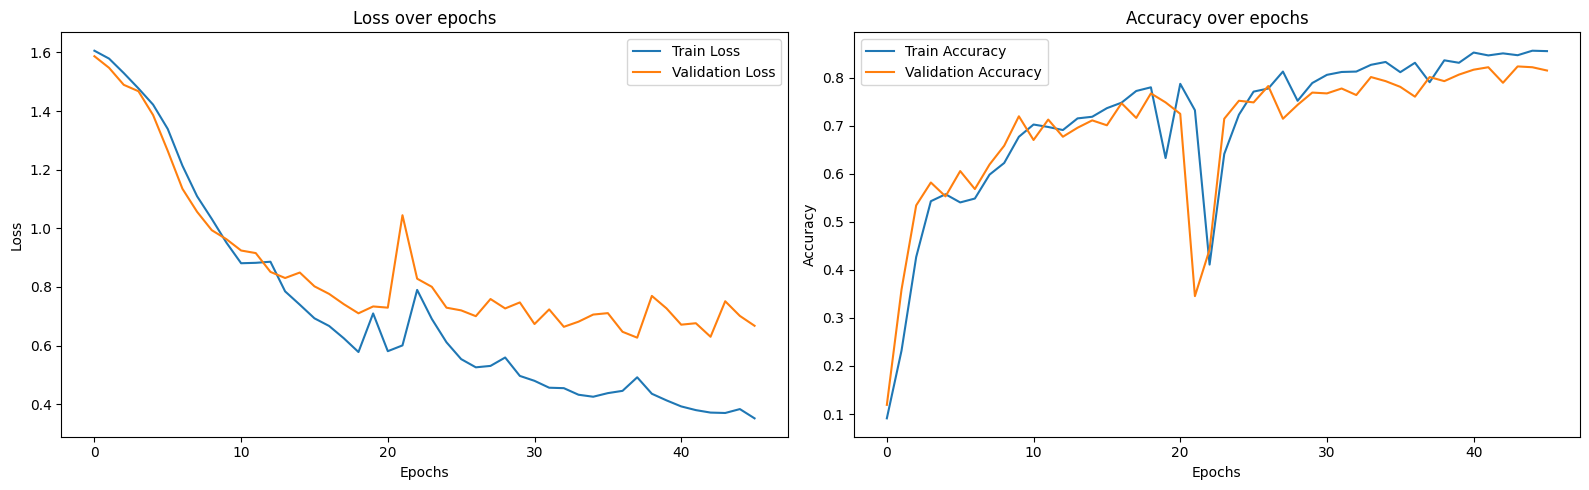

In [19]:
trainer.plot_training_history()


In [20]:
trainer.save_model("./lstm_model_small.pt")

Model saved to ./lstm_model_small.pt


## Bigger model + bidirectional

In [21]:
VOCAB_SIZE = vocab_size
EMBED_DIM = 64
HIDDEN_DIM = 128
OUTPUT_DIM = 5
NUM_LAYERS = 4
DROPOUT_P = 0.4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
BI = True


In [22]:
model = LSTMClassifier(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        num_layers=NUM_LAYERS,
        dropout_p=DROPOUT_P,
        bidirectional=BI
    ).to(device)


In [23]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


LSTMClassifier(
  (embedding): Embedding(193, 64, padding_idx=0)
  (lstm): LSTM(64, 128, num_layers=4, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Number of parameters: 1398085


In [25]:
from training import Trainer

trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    early_stopping=True,
)

trainer.train(train_loader, val_loader, epochs=100)


Epoch 1/100:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 10/10 [01:53<00:00, 11.31s/it]


Epoch 1/100 | Train Loss: 1.4118 | Train Acc: 0.4487 | Val Loss: 1.2397 | Val Acc: 0.5867 | LR: 0.001000


Epoch 2/100: 100%|██████████| 10/10 [01:53<00:00, 11.37s/it]


Epoch 2/100 | Train Loss: 1.1865 | Train Acc: 0.5853 | Val Loss: 1.1111 | Val Acc: 0.6105 | LR: 0.001000


Epoch 3/100: 100%|██████████| 10/10 [01:52<00:00, 11.25s/it]


Epoch 3/100 | Train Loss: 1.0162 | Train Acc: 0.6151 | Val Loss: 0.9276 | Val Acc: 0.6786 | LR: 0.001000


Epoch 4/100: 100%|██████████| 10/10 [01:56<00:00, 11.69s/it]


Epoch 4/100 | Train Loss: 0.8863 | Train Acc: 0.6555 | Val Loss: 0.9289 | Val Acc: 0.7126 | LR: 0.001000
Early stopping counter: 1/8


Epoch 5/100: 100%|██████████| 10/10 [01:54<00:00, 11.45s/it]


Epoch 5/100 | Train Loss: 0.7917 | Train Acc: 0.6963 | Val Loss: 0.8455 | Val Acc: 0.6446 | LR: 0.001000


Epoch 6/100: 100%|██████████| 10/10 [02:03<00:00, 12.34s/it]


Epoch 6/100 | Train Loss: 0.6784 | Train Acc: 0.7197 | Val Loss: 0.6960 | Val Acc: 0.7602 | LR: 0.001000


Epoch 7/100: 100%|██████████| 10/10 [01:54<00:00, 11.43s/it]


Epoch 7/100 | Train Loss: 0.5489 | Train Acc: 0.7788 | Val Loss: 0.6272 | Val Acc: 0.8146 | LR: 0.001000


Epoch 8/100: 100%|██████████| 10/10 [02:05<00:00, 12.54s/it]


Epoch 8/100 | Train Loss: 0.5109 | Train Acc: 0.7950 | Val Loss: 0.7040 | Val Acc: 0.7432 | LR: 0.001000
Early stopping counter: 1/8


Epoch 9/100: 100%|██████████| 10/10 [01:48<00:00, 10.80s/it]


Epoch 9/100 | Train Loss: 0.4592 | Train Acc: 0.8056 | Val Loss: 0.7081 | Val Acc: 0.8095 | LR: 0.001000
Early stopping counter: 2/8


Epoch 10/100: 100%|██████████| 10/10 [02:07<00:00, 12.74s/it]


Epoch 10/100 | Train Loss: 0.4931 | Train Acc: 0.8124 | Val Loss: 0.5339 | Val Acc: 0.8537 | LR: 0.001000


Epoch 11/100: 100%|██████████| 10/10 [02:16<00:00, 13.63s/it]


Epoch 11/100 | Train Loss: 0.3968 | Train Acc: 0.8681 | Val Loss: 0.5617 | Val Acc: 0.8571 | LR: 0.001000
Early stopping counter: 1/8


Epoch 12/100: 100%|██████████| 10/10 [02:23<00:00, 14.35s/it]


Epoch 12/100 | Train Loss: 0.3434 | Train Acc: 0.8775 | Val Loss: 0.5566 | Val Acc: 0.8520 | LR: 0.001000
Early stopping counter: 2/8


Epoch 13/100: 100%|██████████| 10/10 [02:05<00:00, 12.50s/it]


Epoch 13/100 | Train Loss: 0.2639 | Train Acc: 0.9030 | Val Loss: 0.5730 | Val Acc: 0.8741 | LR: 0.001000
Early stopping counter: 3/8


Epoch 14/100: 100%|██████████| 10/10 [02:04<00:00, 12.41s/it]


Epoch 14/100 | Train Loss: 0.2271 | Train Acc: 0.9192 | Val Loss: 0.4465 | Val Acc: 0.8486 | LR: 0.001000


Epoch 15/100: 100%|██████████| 10/10 [01:58<00:00, 11.86s/it]


Epoch 15/100 | Train Loss: 0.2328 | Train Acc: 0.9017 | Val Loss: 0.4917 | Val Acc: 0.8759 | LR: 0.001000
Early stopping counter: 1/8


Epoch 16/100: 100%|██████████| 10/10 [02:01<00:00, 12.10s/it]


Epoch 16/100 | Train Loss: 0.2173 | Train Acc: 0.9200 | Val Loss: 0.4868 | Val Acc: 0.8622 | LR: 0.001000
Early stopping counter: 2/8


Epoch 17/100: 100%|██████████| 10/10 [02:04<00:00, 12.45s/it]


Epoch 17/100 | Train Loss: 0.2002 | Train Acc: 0.9256 | Val Loss: 0.4649 | Val Acc: 0.8520 | LR: 0.001000
Early stopping counter: 3/8


Epoch 18/100: 100%|██████████| 10/10 [01:58<00:00, 11.90s/it]


Epoch 18/100 | Train Loss: 0.2037 | Train Acc: 0.9226 | Val Loss: 0.5058 | Val Acc: 0.8469 | LR: 0.001000
Early stopping counter: 4/8


Epoch 19/100: 100%|██████████| 10/10 [01:59<00:00, 11.93s/it]


Epoch 19/100 | Train Loss: 0.1912 | Train Acc: 0.9268 | Val Loss: 0.4337 | Val Acc: 0.8878 | LR: 0.001000


Epoch 20/100: 100%|██████████| 10/10 [02:03<00:00, 12.36s/it]


Epoch 20/100 | Train Loss: 0.2109 | Train Acc: 0.9260 | Val Loss: 0.5021 | Val Acc: 0.8350 | LR: 0.001000
Early stopping counter: 1/8


Epoch 21/100: 100%|██████████| 10/10 [02:14<00:00, 13.44s/it]


Epoch 21/100 | Train Loss: 0.1923 | Train Acc: 0.9209 | Val Loss: 0.5211 | Val Acc: 0.8878 | LR: 0.001000
Early stopping counter: 2/8


Epoch 22/100: 100%|██████████| 10/10 [02:08<00:00, 12.82s/it]


Epoch 22/100 | Train Loss: 0.1396 | Train Acc: 0.9430 | Val Loss: 0.4901 | Val Acc: 0.8605 | LR: 0.001000
Early stopping counter: 3/8


Epoch 23/100: 100%|██████████| 10/10 [02:01<00:00, 12.12s/it]


Epoch 23/100 | Train Loss: 0.1233 | Train Acc: 0.9490 | Val Loss: 0.4918 | Val Acc: 0.8690 | LR: 0.001000
Early stopping counter: 4/8


Epoch 24/100: 100%|██████████| 10/10 [02:03<00:00, 12.39s/it]


Epoch 24/100 | Train Loss: 0.1124 | Train Acc: 0.9558 | Val Loss: 0.4747 | Val Acc: 0.8776 | LR: 0.001000
Early stopping counter: 5/8


Epoch 25/100: 100%|██████████| 10/10 [02:08<00:00, 12.82s/it]


Epoch 25/100 | Train Loss: 0.1167 | Train Acc: 0.9519 | Val Loss: 0.5259 | Val Acc: 0.8690 | LR: 0.000500
Early stopping counter: 6/8


Epoch 26/100: 100%|██████████| 10/10 [02:03<00:00, 12.31s/it]


Epoch 26/100 | Train Loss: 0.1008 | Train Acc: 0.9609 | Val Loss: 0.5169 | Val Acc: 0.8793 | LR: 0.000500
Early stopping counter: 7/8


Epoch 27/100: 100%|██████████| 10/10 [02:04<00:00, 12.43s/it]


Epoch 27/100 | Train Loss: 0.0979 | Train Acc: 0.9532 | Val Loss: 0.5067 | Val Acc: 0.8946 | LR: 0.000500
Early stopping counter: 8/8
Early stopping triggered after 27 epochs.


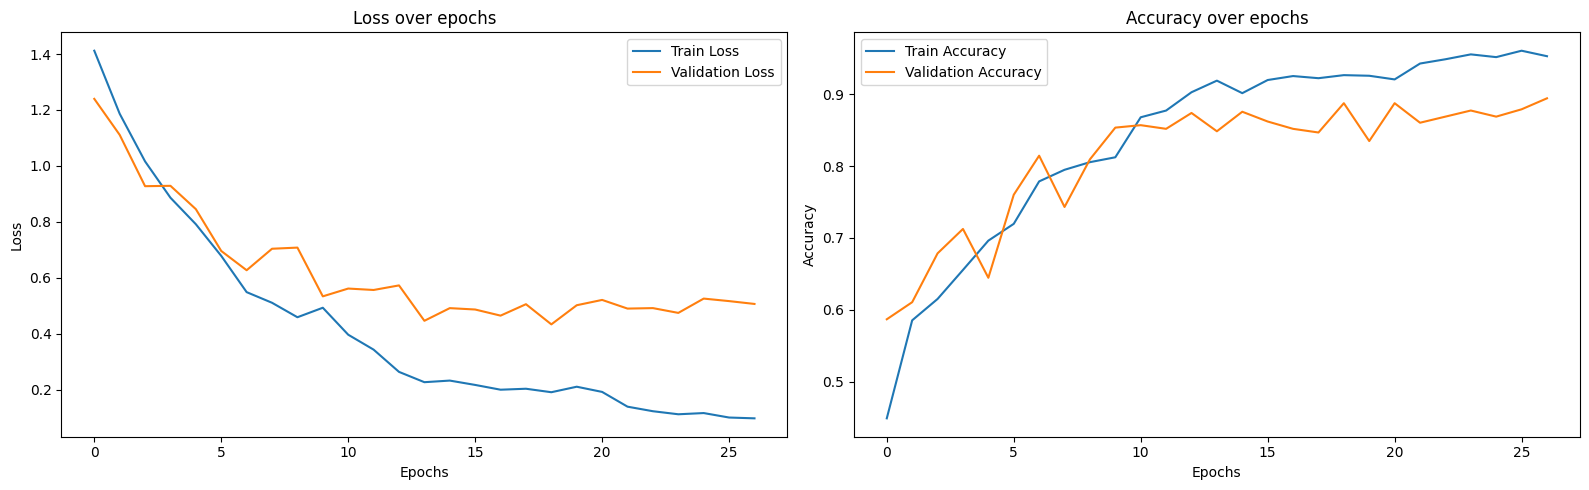

In [26]:
trainer.plot_training_history()

In [27]:
trainer.save_model("./lstm_model_big.pt")

Model saved to ./lstm_model_big.pt


### Small lstm with just bidirection + info acc per class

In [28]:
VOCAB_SIZE = vocab_size
EMBED_DIM = 32
HIDDEN_DIM = 64
OUTPUT_DIM = 5
NUM_LAYERS = 2
DROPOUT_P = 0.4
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
BIDIRECTIONAL = True


In [29]:
model = LSTMClassifier(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        hidden_dim=HIDDEN_DIM,
        output_dim=OUTPUT_DIM,
        num_layers=NUM_LAYERS,
        dropout_p=DROPOUT_P,
        bidirectional=BIDIRECTIONAL
    ).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

LSTMClassifier(
  (embedding): Embedding(193, 32, padding_idx=0)
  (lstm): LSTM(32, 64, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Number of parameters: 156325


In [30]:
from training import Trainer

trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    early_stopping=True,
    early_stopping_patience=5 # more impatient model
)


In [31]:
trainer.train(train_loader, val_loader, epochs=100)

Epoch 1/100: 100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


Epoch 1/100 | Train Loss: 1.5994 | Train Acc: 0.1497 | Val Loss: 1.5779 | Val Acc: 0.2415 | LR: 0.001000


Epoch 2/100:  20%|██        | 2/10 [00:15<01:00,  7.53s/it]


KeyboardInterrupt: 

In [ ]:
trainer.plot_training_history()
trainer.save_model("./lstm_model_small_bi.pt")